# Connecting Drive

In [1]:
# mount google drive
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


# Data

In [153]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import IPython
import datetime
import random
import pickle

import os
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

In [154]:
# connect to database
conn = sqlite3.connect('/content/drive/My Drive/data/seabirdbank.db')
# conn = sqlite3.connect('/home/amdroy/MEGA/DATA/seabirdbank.db')

## import dataset

In [155]:
request = "SELECT trip, datetime, lon, lat, pressure, gaps, step_speed FROM gps_tdr_interp \
            INNER JOIN trip ON gps_tdr_interp.trip = trip.id \
            INNER JOIN bird ON trip.bird = bird.id \
            WHERE bird.species = 'SV' \
            ORDER BY trip, datetime"

data = pd.read_sql_query(request, conn)

In [156]:
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d %H:%M:%S')
data

,trip,datetime,lon,lat,pressure,gaps,step_speed
0,G1107_12_SV_T1,2007-11-19 13:42:18,-78.958173,-8.566655,-0.69,FALSE,NaN
1,G1107_12_SV_T1,2007-11-19 13:42:19,-78.958148,-8.566714,-0.66,FALSE,7.120624
2,G1107_12_SV_T1,2007-11-19 13:42:20,-78.958134,-8.566773,-0.66,FALSE,6.745794
3,G1107_12_SV_T1,2007-11-19 13:42:21,-78.958121,-8.566839,-0.66,FALSE,7.484667
4,G1107_12_SV_T1,2007-11-19 13:42:22,-78.958112,-8.566910,-0.66,FALSE,7.965019
...,...,...,...,...,...,...,...
1488391,P1113_50_SV_T2,2013-11-25 05:23:26,-77.264830,-11.773700,-0.94,FALSE,8.459780
1488392,P1113_50_SV_T2,2013-11-25 05:23:27,-77.264860,-11.773660,-0.94,FALSE,5.258289
1488393,P1113_50_SV_T2,2013-11-25 05:23:28,-77.264900,-11.773700,-0.94,FALSE,6.162400
1488394,P1113_50_SV_T2,2013-11-25 05:23:29,-77.264930,-11.773740,-0.94,FALSE,5.072946


In [157]:
def rle(inarray):
        """ run length encoding. Partial credit to R rle function. 
            Multi datatype arrays catered for including non Numpy
            returns: tuple (runlengths, startpositions, values) """
        ia = np.asarray(inarray)                # force numpy
        n = len(ia)
        if n == 0: 
            return (None, None, None)
        else:
            y = np.array(ia[1:] != ia[:-1])     # pairwise unequal (string safe)
            i = np.append(np.where(y), n - 1)   # must include last element posi
            z = np.diff(np.append(-1, i))       # run lengths
            p = np.cumsum(np.append(0, z))[:-1] # positions
            return(z, p, ia[i])

In [158]:
## check max speed
list_ok = []
for k in data.trip.unique():
    # check maximal speed
    max_speed = np.max(data.step_speed[data.trip == k])
    if max_speed < 50:
        # check if there are dives
        dive = (np.median(data.pressure[data.trip == k]) + 1 ) < np.max(data.pressure[data.trip == k])
        if dive:
            # check longest gap
            if (np.median(data.pressure[data.trip == k]) + 1 ) < np.max(data.pressure[data.trip == k]):
                rle_gaps = rle(np.where(data.gaps[data.trip == k] == 'TRUE', 1, 0))
                longest_gaps = np.max(rle_gaps[0][rle_gaps[2] == 1])
                if longest_gaps < 10:
                    list_ok.append(k)

In [159]:
data = data[data.trip.isin(list_ok)]
data

,trip,datetime,lon,lat,pressure,gaps,step_speed
403290,G1107_9_SV_T1,2007-11-18 14:30:14,-78.96173,-8.569865,0.68,FALSE,NaN
403291,G1107_9_SV_T1,2007-11-18 14:30:15,-78.96174,-8.569925,0.71,FALSE,6.787599
403292,G1107_9_SV_T1,2007-11-18 14:30:16,-78.96173,-8.569981,0.68,FALSE,6.295377
403293,G1107_9_SV_T1,2007-11-18 14:30:17,-78.96170,-8.570024,0.68,FALSE,5.814952
403294,G1107_9_SV_T1,2007-11-18 14:30:18,-78.96167,-8.570073,0.68,FALSE,6.433678
...,...,...,...,...,...,...,...
1363156,P1113_33_SV_T4,2013-11-21 07:16:47,-77.26390,-11.773870,1.68,FALSE,10.916510
1363157,P1113_33_SV_T4,2013-11-21 07:16:48,-77.26401,-11.773870,1.68,FALSE,11.660360
1363158,P1113_33_SV_T4,2013-11-21 07:16:49,-77.26411,-11.773880,1.68,FALSE,11.641150
1363159,P1113_33_SV_T4,2013-11-21 07:16:50,-77.26417,-11.773880,1.68,FALSE,6.680660


## split  dataset

In [160]:
test_trajs = np.random.choice(data.trip.unique(), 30)
train_trajs = np.random.choice(data.trip.unique(), 70)

data_train = data[data.trip.isin(train_trajs)]
data_test = data[data.trip.isin(test_trajs)]

In [161]:
# data_train.to_csv('./hmm/data_train.csv')
# data_test.to_csv('./hmm/data_test.csv')

## create dataloader

In [162]:
def dist_ortho(lon1, lat1, lon2, lat2):
    R = 6377726
    pi = np.pi
    a = np.sin((lat1 - lat2)/2*pi/180)**2
    b = np.cos(lat1*pi/180)*np.cos(lat2*pi/180)
    c = np.sin((lon1- lon2)/2* pi/180)**2

    dist = R * 2* np.arcsin( np.sqrt(a + b*c))
    return dist

In [163]:
class TrajDataSet(Dataset):
    def __init__(self,  df, epoch, transform=None):
        self.df = df.set_index(np.arange(len(df))) #reorder idx
        self.epoch = epoch
        self.start_idx = np.where([self.df.trip[i]==self.df.trip[i+self.epoch] for i in range(len(self.df)-self.epoch)])[0]
        self.transform = transform
        
    def __len__(self):
        return len(self.start_idx)

    def __getitem__(self, idx):
        
        i = self.start_idx[idx]
        
        traj = self.df.loc[i:i+self.epoch-1, ('lon', 'lat')]           
        traj = np.array(traj).T
        
        
        dive = self.df.loc[i:i+self.epoch-1, 'pressure']
        dive = np.array(dive)
        
        sample = (traj, dive)
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample

class Threshold(object):
    """Define dives with threshold

    Args:
        threshold value 
    """

    def __init__(self, threshold):
        self.threshold = threshold

    def __call__(self, sample):
        traj, dive = sample

        # change resolution
        dive_new = np.where( (dive - np.median(dive)) > self.threshold, 1, 0)

        return (traj, dive_new)
    
    
class Rescale(object):
    """Rescale the output in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size
    """

    def __init__(self, ratio, method='max'):
        self.ratio = ratio
        self.method = method

    def __call__(self, sample):
        traj, dive = sample

        # change resolution
        if self.method == 'max':
            dive_new = [np.max(dive[i:i+self.ratio+1]) for i in range(len(dive)) if i%self.ratio==0]
            
        if self.method == 'mean':
            dive_new = [np.mean(dive[i:i+self.ratio+1]) for i in range(len(dive)) if i%self.ratio==0]

        return (traj, dive_new)
    
class DistMatrix(object):
    """Convert ndarrays in sample to Tensors."""    
    def __call__(self, sample):
        traj, dive = sample
        lon = np.vstack([traj[0] for i in range(traj.shape[1])])
        lat = np.vstack([traj[1]  for i in range(traj.shape[1])])
        dd = dist_ortho(lon, lat, lon.T, lat.T)
        
        return (dd/5000, dive)
    
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
        
    def __call__(self, sample):
        traj, dive = sample
        traj, dive = (torch.FloatTensor(traj), torch.FloatTensor(dive))
        return (traj.unsqueeze(0), dive.unsqueeze(0))

In [164]:
# Hyperparameters
epoch = 600
batch_size = 8
learning_rate = 0.001

In [165]:
train_set = TrajDataSet(data_train, epoch, transform = transforms.Compose([Threshold(1), DistMatrix(), ToTensor()]))
test_set = TrajDataSet(data_test, epoch, transform = transforms.Compose([Threshold(1), DistMatrix(), ToTensor()]))

test_idx = np.random.randint(len(test_set), size = 100)
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers = 2, shuffle = True)

## plot data

In [166]:
train_set_ = TrajDataSet(data_train, epoch)
d = DistMatrix()
t = Threshold(1)

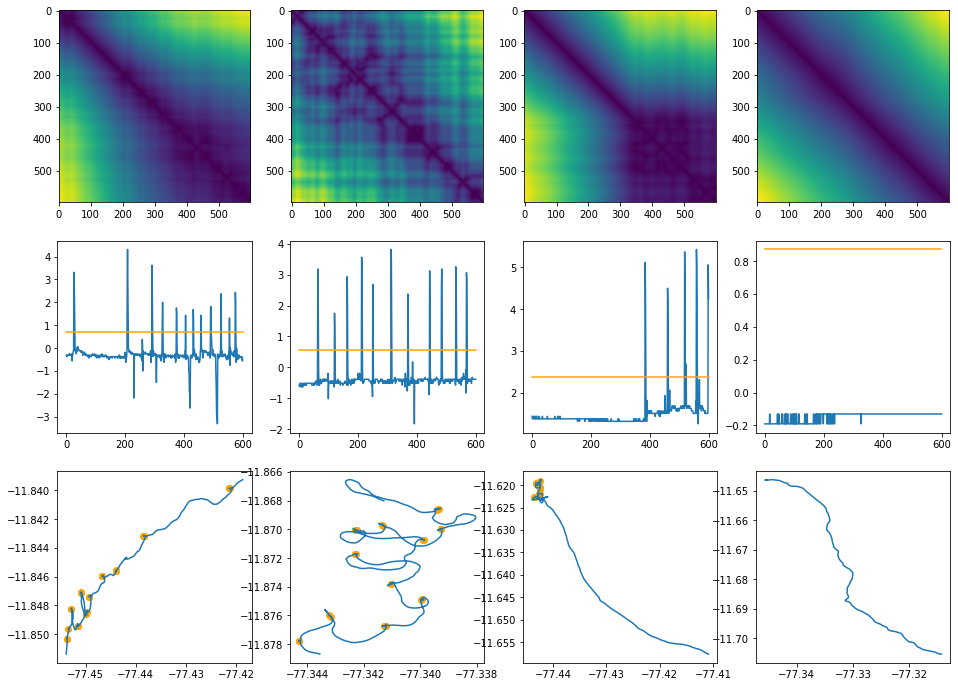

In [167]:
plt.figure(figsize=(16, 12))

for i in range(4):
    ii = np.random.randint(len(train_set_))
    matrix_dist, pressure = d(train_set_[ii])
    traj, dive = t(train_set_[ii])

    plt.subplot(3,4, i+1)
    plt.imshow(matrix_dist)

    plt.subplot(3,4, i+5)
    plt.plot(pressure)
    plt.plot((np.median(pressure) + 1) * np.ones(len(pressure)), c='orange')

    plt.subplot(3,4, i+9)
    plt.plot(traj[0,:], traj[1,:])
    plt.scatter(traj[0, np.array(dive, dtype = 'bool')], traj[1,np.array(dive, dtype = 'bool')], c='orange')

# Neural Network

In [168]:
class ConvNet(nn.Module):

    def __init__(self):
        super(ConvNet, self).__init__()

        self.threshold_1 = nn.Sequential(
            nn.BatchNorm2d(1),
            nn.Conv2d(1, 1, kernel_size = 1, stride = 1, padding = 0, dilation = 1, bias = True),
            nn.Sigmoid()
        )

        self.threshold_2 = nn.Sequential(
            nn.BatchNorm1d(1),
            nn.Conv1d(1, 1, kernel_size = 1, stride = 1, padding = 0, dilation = 1, bias = True),
            nn.Sigmoid()
        )

    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        out = self.threshold_1(x)
        out = torch.sum(out, 2)
        out = self.threshold_2(out)
        return out

In [169]:
def get_score(out, y):
    out = torch.round(out)
    return 1-(torch.mean(out[y == True]) + (1-torch.mean(out[y == False])))/2

In [177]:
# Loss and optimizer
model = ConvNet()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [178]:
list_loss = []
list_score = []
i = 0
for batch, (x, y) in enumerate(train_loader):
    i+=1
    
    # Train the model
    model.train()
    
#     # send to GPU
#     x, y = x.to(device), y.to(device)

    # Run the forward pass
    out = model(x)
    loss = get_score(out, y) + criterion(out, y)

    # Backprop and perform optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
#     if (i + 1) % 1000 == 0:  
#         # Test the model
#         model.eval()
#         with torch.no_grad():
#             real = []
#             estim = []

#             for idx in test_idx:
#                 (x,y) = test_set[idx]
#                 x = x.unsqueeze(0)
#                 loss = score(out, y)
#                 real.append( y.squeeze().detach().numpy() )
#                 estim.append( out.squeeze().detach().numpy() )

#             real = np.hstack(real)
#             estim = np.hstack(estim)

#             # no dive prediction performance
#             no_dive_prediction = [estim[i] for i in range(estim.shape[0]) if not real[i]]
#             true_no_dive = 1-np.sum(no_dive_prediction)/len(no_dive_prediction)

#             # dive prediction performance
#             dive_prediction = [estim[i] for i in range(estim.shape[0]) if real[i]]
#             true_dive = np.sum(dive_prediction)/len(dive_prediction)

#             score = (true_no_dive + true_dive)/2
    
    score = 1-get_score(out,y)
    list_loss.append(loss.item())
    list_score.append(score)

    if (i + 1) % 10 == 0:  
        print('Step {}, Loss: {}, Score: {} %'
                .format(i + 1, loss.item(), score*100))

Step 10, Loss: 1.4293532371520996, Score: 56.67649459838867 %
Step 20, Loss: 1.4448649883270264, Score: 54.56898880004883 %
Step 30, Loss: 1.403480052947998, Score: 56.707061767578125 %
Step 40, Loss: 1.408820629119873, Score: 55.493675231933594 %
Step 50, Loss: 1.3874222040176392, Score: 57.07049560546875 %
Step 60, Loss: 1.3830280303955078, Score: 56.21558380126953 %
Step 70, Loss: 1.3693571090698242, Score: 56.82297897338867 %
Step 80, Loss: 1.367089867591858, Score: 56.5272216796875 %
Step 90, Loss: 1.347596287727356, Score: 57.668067932128906 %
Step 100, Loss: 1.3443814516067505, Score: 57.07973861694336 %
Step 110, Loss: 1.3749357461929321, Score: 53.187477111816406 %
Step 120, Loss: 1.3362717628479004, Score: 56.08561706542969 %
Step 130, Loss: 1.3110113143920898, Score: 58.04718780517578 %
Step 140, Loss: 1.3353214263916016, Score: 55.03151321411133 %
Step 150, Loss: 1.3530640602111816, Score: 52.672325134277344 %
Step 160, Loss: 1.2869244813919067, Score: 58.14393615722656 %
S

KeyboardInterrupt: ignored

In [179]:
out

tensor([[[0.3910, 0.3924, 0.3941,  ..., 0.4333, 0.4319, 0.4304]],

        [[0.5646, 0.5662, 0.5678,  ..., 0.6422, 0.6421, 0.6420]],

        [[0.3787, 0.3801, 0.3816,  ..., 0.4667, 0.4655, 0.4645]],

        ...,

        [[0.6230, 0.6243, 0.6257,  ..., 0.5755, 0.5730, 0.5711]],

        [[0.6527, 0.6524, 0.6520,  ..., 0.6489, 0.6490, 0.6489]],

        [[0.3075, 0.3089, 0.3102,  ..., 0.4663, 0.4672, 0.4682]]],
       grad_fn=<SigmoidBackward>)

In [136]:
out

tensor([[[0.0041, 0.0041, 0.0041,  ..., 0.0059, 0.0059, 0.0060]],

        [[0.0051, 0.0051, 0.0051,  ..., 0.0018, 0.0017, 0.0017]],

        [[0.0022, 0.0023, 0.0023,  ..., 0.0021, 0.0020, 0.0020]],

        ...,

        [[0.0022, 0.0022, 0.0022,  ..., 0.0012, 0.0012, 0.0011]],

        [[0.0018, 0.0018, 0.0018,  ..., 0.0024, 0.0023, 0.0023]],

        [[0.0151, 0.0153, 0.0155,  ..., 0.0204, 0.0202, 0.0200]]],
       grad_fn=<SigmoidBackward>)

# First time passage

In [ ]:
def residence_time(dist_matrix, radius):
    residence_matrix = dist_matrix < radius
    residence = [sum(residence_matrix[:,i]) for i in range(dist_matrix.shape[0])]
    return np.array(residence)

def first_time_passage(dist_matrix, radius):
    first_passage = np.zeros(dist_matrix.shape[0])
    residence_matrix = dist_matrix < radius
    if np.sum(residence_matrix) > 0 :
        for i in range(dist_matrix.shape[0]):
            idx = np.where(residence_matrix[:,i])[0]
            delta = np.diff(idx)
            # get index start
            i_start = i
            while i_start in idx:
                i_start -=1
            # get index end
            i_end = i
            while i_end in idx:
                i_end +=1
            # get number of point
            first_passage[i] = i_end-i_start+1

    return first_passage

In [ ]:
radius = 250/5000
time_threshold = 60

In [ ]:
real = []
estim = []

for idx in test_idx:
    (x,y) = test_set[idx]
    x = x.squeeze().numpy()
    
    residence = residence_time(x, radius)
    out = residence > time_threshold
    
    # dive prediction
    real.append( y.squeeze().detach().numpy() )
    estim.append( 1*out )
    
real = np.hstack(real)
estim = np.hstack(estim)

# no dive prediction performance
no_dive_prediction = [estim[i] for i in range(estim.shape[0]) if not real[i]]
true_no_dive = 1-np.sum(no_dive_prediction)/len(no_dive_prediction)

# dive prediction performance
dive_prediction = [estim[i] for i in range(estim.shape[0]) if real[i]]
true_dive = np.sum(dive_prediction)/len(dive_prediction)

score = (true_no_dive + true_dive)/2
score

In [ ]:
true_no_dive

In [ ]:
true_dive

In [ ]:
np.sum(real == 0)/len(real)

In [ ]:
np.sum(real == estim)/len(real)